# What is Beta in Finance?

Beta ($\beta$) is a measure of a stock's volatility relative to the overall market or a reference stock. It is often used to assess the risk of an investment compared to the broader market. A stock with a high beta is more volatile and thus riskier than the market, while a low-beta stock is less volatile.

## Definition of Beta

Beta is defined as:

$$\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}$$

Where:
- R_i: Return of the individual stock
- R_m: Return of the market index
- $\text{Cov}(R_i, R_m)$: Covariance between the stock's returns and the market's returns
- $\text{Var}(R_m)$: Variance of the market's returns

## Interpretation of Beta

- **$\beta = 1$**: The stock's returns move in perfect correlation with the market. It has the same risk as the market.
- **$\beta > 1$**: The stock is more volatile than the market.
- **$\beta < 1$**: The stock is less volatile than the market.
- **$\beta < 0$**: Rare but possible, indicating the stock moves inversely to the market.

For more information, refer to [this link](https://www.investopedia.com/investing/beta-know-risk/).

# Beta Prediction Model
This notebook included a robust 45-day forward-looking Beta (the Beta calculated using data for the next 45 days) prediction model.

## Objectives:

- Build a robust model that accurately predicts the 45-day forward-looking Beta for a given stock.
- Evaluate to a 'Baseline' model that predicts the average value of beta every time, we expect a significant improvement.
- Find relevant features to understand the factors predicting Beta.

## Method:
- We choose 100 stocks randomly and use the S&P 500 as market reference to calculate the Beta.
- In addition to the 45-day forward-looking Beta, we also calculate past Beta, correlation and mean daily returns and volumes over last 45 and 20 days.
- We train 3 models: Linear Regressor, Random Forest Regressor, and Gradient Boost Regressor.

## Results:

- Best performing model: Random Forest Regressor. We calculated a RMSE of 0.27 and a r2-score of 0.76. 
- For a target with an average of about 1 and a STD of 0.54, a RMSE of 0.27 represents an average difference of less than 30% to the real value and a 50% decrease compared to a 'Baseline' model that guesses the mean value everytime.
- The R2 score of 0.76 implies that 76% of the variance in the target variable is explained by this model, compared to 0% in the simple 'Baseline' model.
- After extracting the Feature Importances, the results show that for linear regression, the 45-day past Covariances are the most relevant feature by far. However, for the RF and GB Regressors the 45-day past Beta is the largest predictor of the 45-day future beta.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# Feature Engineering and Data Preprocessing

### We use the yfinance library to extract data for 100 random stocks belonging to the S&P 500 from the last 10 years and use the S&P 500 itself as a reference (market) to calculate the covariances and betas

In [167]:
# Fetch S&P 500 tickers from a public source (wikipedia in this case)
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(sp500_url)[0]  # The first table on the page
sp500_tickers = table['Symbol'].tolist()

# Randomly select a specified number of tickers
num_tickers_to_select = 100
random.seed(123)
stocks = random.sample(sp500_tickers, num_tickers_to_select)

print(stocks)

['AXP', 'DRI', 'ANET', 'RTX', 'GE', 'DHR', 'BKR', 'SYF', 'UAL', 'TJX', 'GOOGL', 'FITB', 'KMB', 'LEN', 'EOG', 'EQIX', 'TRGP', 'ZTS', 'CZR', 'BWA', 'EQT', 'WELL', 'WFC', 'PCAR', 'GLW', 'CPB', 'MMM', 'URI', 'HIG', 'REGN', 'ZBRA', 'TT', 'MA', 'FIS', 'ANSS', 'ABBV', 'EBAY', 'PNW', 'HES', 'AVB', 'AMZN', 'T', 'NDSN', 'AVGO', 'BLK', 'ROST', 'APD', 'DG', 'GDDY', 'LMT', 'IEX', 'CVS', 'HUM', 'SMCI', 'ALL', 'YUM', 'DTE', 'EQR', 'JPM', 'STX', 'INCY', 'CI', 'SO', 'MRK', 'MCO', 'K', 'LLY', 'SPG', 'VLO', 'AMD', 'FOX', 'WMB', 'MSI', 'JBL', 'HAL', 'NXPI', 'KIM', 'MNST', 'CRM', 'UNP', 'VRSK', 'IR', 'JCI', 'NSC', 'GIS', 'FRT', 'JBHT', 'ALLE', 'PSA', 'SNPS', 'CDW', 'PCG', 'ACGL', 'PODD', 'NWSA', 'CMI', 'CCL', 'EPAM', 'WMT', 'LRCX']


In [168]:
# Define the reference market index and download data
reference_index = '^GSPC'  # S&P 500
today = datetime.now()
start_date = today - timedelta(days=20 * 365)
data = yf.download(stocks + [reference_index], start=start_date, end=today)
data.head(10)

[*********************100%***********************]  101 of 101 completed


Price                     Adj Close                                       \
Ticker                         ABBV      ACGL        ALL ALLE        AMD   
Date                                                                       
2005-01-05 00:00:00+00:00       NaN  4.153333  30.970819  NaN  19.750000   
2005-01-06 00:00:00+00:00       NaN  4.147778  31.239874  NaN  19.719999   
2005-01-07 00:00:00+00:00       NaN  4.191111  31.203180  NaN  19.920000   
2005-01-10 00:00:00+00:00       NaN  4.212222  31.392733  NaN  20.129999   
2005-01-11 00:00:00+00:00       NaN  4.183333  31.245983  NaN  14.860000   
2005-01-12 00:00:00+00:00       NaN  4.177778  31.368273  NaN  15.020000   
2005-01-13 00:00:00+00:00       NaN  4.163333  31.502810  NaN  15.160000   
2005-01-14 00:00:00+00:00       NaN  4.140000  31.484449  NaN  15.160000   
2005-01-18 00:00:00+00:00       NaN  4.207778  31.539490  NaN  15.500000   
2005-01-19 00:00:00+00:00       NaN  4.221111  30.983049  NaN  15.500000   

Price                                                                    ...  \
Ticker                       AMZN ANET       ANSS        APD        AVB  ...   
Date                                                                     ...   
2005-01-05 00:00:00+00:00  2.0885  NaN  16.200001  32.616695  34.617249  ...   
2005-01-06 00:00:00+00:00  2.0525  NaN  15.720000  32.817009  35.175930  ...   
2005-01-07 00:00:00+00:00  2.1160  NaN  14.865000  32.994419  35.126499  ...   
2005-01-10 00:00:00+00:00  2.0920  NaN  15.210000  33.017334  34.706249  ...   
2005-01-11 00:00:00+00:00  2.0820  NaN  15.000000  32.422112  33.925125  ...   
2005-01-12 00:00:00+00:00  2.1150  NaN  15.035000  32.839912  33.915237  ...   
2005-01-13 00:00:00+00:00  2.1300  NaN  14.735000  32.530861  33.860840  ...   
2005-01-14 00:00:00+00:00  2.2275  NaN  14.740000  33.017334  34.038818  ...   
2005-01-18 00:00:00+00:00  2.2290  NaN  14.625000  33.211914  34.241531  ...   
2005-01-19 00:00:00+00:00  2.1980  NaN  14.585000  32.731174  34.572773  ...   

Price                        Volume                                            \
Ticker                          VLO VRSK    WELL       WFC      WMB       WMT   
Date                                                                            
2005-01-05 00:00:00+00:00   7802408  NaN  523900   7694600  3728901  24724500   
2005-01-06 00:00:00+00:00   7185392  NaN  371300   8887600  4184495  42086400   
2005-01-07 00:00:00+00:00   5539141  NaN  251800   6573200  2446394  28980900   
2005-01-10 00:00:00+00:00   5811766  NaN  200000   7685200  2938911  25962000   
2005-01-11 00:00:00+00:00   5219036  NaN  290100   7490800  2768155  19990200   
2005-01-12 00:00:00+00:00   6974469  NaN  411100  11469200  4304220  25010700   
2005-01-13 00:00:00+00:00  11446960  NaN  319200  10710000  3284102  28767300   
2005-01-14 00:00:00+00:00   9156561  NaN  303800  10155000  3655299  22460100   
2005-01-18 00:00:00+00:00  11187025  NaN  331400  10051000  3807655  29686800   
2005-01-19 00:00:00+00:00   5669546  NaN  530900   6215400  2147694  20841900   

Price                                                        
Ticker                         YUM     ZBRA ZTS       ^GSPC  
Date                                                         
2005-01-05 00:00:00+00:00  2126839  1054400 NaN  1738900000  
2005-01-06 00:00:00+00:00  1802458   280000 NaN  1569100000  
2005-01-07 00:00:00+00:00  2023349   351600 NaN  1477900000  
2005-01-10 00:00:00+00:00  2108200   422200 NaN  1490400000  
2005-01-11 00:00:00+00:00  2244239   579600 NaN  1488800000  
2005-01-12 00:00:00+00:00  2955040   725700 NaN  1562100000  
2005-01-13 00:00:00+00:00  2609794   377800 NaN  1510300000  
2005-01-14 00:00:00+00:00  4191639   466900 NaN  1335400000  
2005-01-18 00:00:00+00:00  4423936  1112500 NaN  1596800000  
2005-01-19 00:00:00+00:00  2524109   837400 NaN  1498700000  

[10 rows x 606 columns]

In [169]:
# Since we note some stocks have several Nan values, we filter these data and keep only stocks with less than 100 nans
stocks_kept =[reference_index]
for ticker in stocks:
    if data['Adj Close'][ticker].isna().sum() < 100:
        stocks_kept.append(ticker)
print(f'We kept {len(stocks_kept)} stocks')
data = data.loc[:, pd.IndexSlice[:, stocks_kept]]

We kept 80 stocks


In [170]:
# Get some info about our data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5030 entries, 2005-01-05 00:00:00+00:00 to 2024-12-30 00:00:00+00:00
Columns: 480 entries, ('Adj Close', '^GSPC') to ('Volume', 'LRCX')
dtypes: float64(400), int64(80)
memory usage: 18.5 MB


In [171]:
# Calculate daily returns
daily_returns = data['Adj Close'].pct_change().dropna()
daily_returns.head(10)

Ticker,^GSPC,AXP,DRI,RTX,GE,DHR,BKR,TJX,GOOGL,FITB,...,FRT,JBHT,PSA,SNPS,PCG,ACGL,CMI,CCL,WMT,LRCX
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-06 00:00:00+00:00,0.003506,-0.005143,0.037922,0.000594,0.008071,0.000542,0.013069,0.000406,-0.025632,-0.004091,...,0.007202,0.013545,0.002848,-0.009408,-0.006796,-0.001338,-0.004553,0.007199,0.014262,-0.007342
2005-01-07 00:00:00+00:00,-0.001431,-0.007385,0.036537,-0.010780,-0.006074,0.001805,-0.012183,-0.004864,0.028109,-0.006701,...,0.000408,-0.018991,0.004735,0.004469,-0.007154,0.010447,-0.019211,0.002441,-0.001110,0.003114
2005-01-10 00:00:00+00:00,0.003423,0.002046,-0.004583,-0.002799,-0.002500,-0.003242,0.001935,0.010998,0.006242,0.001741,...,0.000205,0.015774,-0.003770,0.003893,0.020050,0.005037,-0.009993,-0.012348,-0.005001,0.005045
2005-01-11 00:00:00+00:00,-0.006100,-0.009282,-0.001062,0.004211,-0.014202,0.006688,-0.005551,-0.006850,-0.007793,-0.007820,...,-0.013067,-0.014823,-0.004351,-0.009972,-0.008600,-0.006858,0.013189,-0.012326,-0.002420,-0.012741
2005-01-12 00:00:00+00:00,0.003981,-0.002248,0.024459,0.017772,0.007909,0.006464,0.013349,0.008519,0.009507,-0.009197,...,-0.007861,-0.011225,-0.000191,-0.008954,0.012082,-0.001328,0.003454,0.000713,0.009144,0.043019
2005-01-13 00:00:00+00:00,-0.008630,-0.006949,0.001730,-0.013146,-0.012612,-0.018733,0.004072,-0.002413,-0.000256,-0.016132,...,0.013136,-0.016909,0.005892,-0.011858,0.007040,-0.003458,0.000529,0.003385,-0.008136,-0.011999
2005-01-14 00:00:00+00:00,0.006005,-0.003026,-0.007254,0.003380,0.008232,-0.000909,0.008350,0.006855,0.023755,-0.000225,...,-0.001647,0.037101,0.006047,0.001714,0.015197,-0.005604,0.010849,0.016335,0.006525,0.032258
2005-01-18 00:00:00+00:00,0.009675,0.008156,0.023660,0.012482,0.012388,0.000546,0.007334,0.018422,0.019653,0.059762,...,0.015048,0.005686,0.034373,0.009698,0.005389,0.016372,0.010603,0.011880,0.009261,0.001103
2005-01-19 00:00:00+00:00,-0.009490,-0.001693,-0.014276,-0.011252,-0.014461,-0.007276,0.002114,-0.011011,-0.032369,-0.010388,...,0.004874,-0.016726,-0.005629,-0.031638,0.005658,0.003169,-0.003368,0.009151,-0.013030,-0.037826


### Now we want to calculate the 45-day forward-looking Beta for our stocks (our target) but we also need to create some features that can be useful for our model. We therefore calculate the variances, covariances and betas but also correlations and mean volumes

In [172]:
# Calculate market's Variances and Covariances taking the last 45 days for each day and define the beta
variances45 = daily_returns['^GSPC'].rolling(45).var()
covariances45 = daily_returns.rolling(45).cov(daily_returns['^GSPC'])
beta45 = covariances45.div(variances45, axis=0)
# We look at the tail of the betas
beta45.tail(10)

Ticker,^GSPC,AXP,DRI,RTX,GE,DHR,BKR,TJX,GOOGL,FITB,...,FRT,JBHT,PSA,SNPS,PCG,ACGL,CMI,CCL,WMT,LRCX
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-16 00:00:00+00:00,1.0,1.272880,0.934275,0.620165,1.143321,0.191882,1.206326,0.411444,1.188532,1.205160,...,0.259499,1.072660,-0.198508,2.420701,0.179609,1.312065,0.942278,1.436934,0.170079,2.193861
2024-12-17 00:00:00+00:00,1.0,1.313372,0.978652,0.615540,1.113678,0.167126,1.262830,0.393688,1.205936,1.215741,...,0.265776,1.006254,-0.205373,2.457637,0.061979,1.420510,0.977656,1.539897,0.172901,2.099127
2024-12-18 00:00:00+00:00,1.0,1.422357,1.111064,0.698458,1.102881,0.338195,1.161150,0.480669,1.267085,1.454160,...,0.634650,1.115503,0.300050,1.946669,0.332768,1.106499,0.962088,1.680400,0.403578,1.523055
2024-12-19 00:00:00+00:00,1.0,1.402093,1.039216,0.681106,1.078989,0.363639,1.157392,0.476924,1.284437,1.453054,...,0.634435,1.076190,0.296621,2.009745,0.320626,1.113389,0.966371,1.704381,0.421442,1.598695
2024-12-20 00:00:00+00:00,1.0,1.414986,1.070434,0.692958,1.127213,0.403849,1.152450,0.479540,1.275762,1.460155,...,0.689735,1.078440,0.398617,1.925417,0.383951,1.167284,0.941675,1.854218,0.348299,1.565875
2024-12-23 00:00:00+00:00,1.0,1.435656,1.017757,0.688060,1.126084,0.399027,1.142196,0.466349,1.291751,1.460488,...,0.675829,1.047240,0.406688,1.899572,0.393821,1.182504,0.918662,1.740169,0.287708,1.616795
2024-12-24 00:00:00+00:00,1.0,1.413814,1.002279,0.677312,1.155160,0.418187,1.147771,0.480205,1.259904,1.402156,...,0.664476,1.038266,0.394133,1.885811,0.419300,1.178105,0.904290,1.669451,0.348945,1.560867
2024-12-26 00:00:00+00:00,1.0,1.415582,0.991327,0.675571,1.118480,0.401904,1.141911,0.474070,1.263385,1.403047,...,0.668254,1.033071,0.397176,1.886645,0.423734,1.174648,0.900558,1.674419,0.354311,1.560993
2024-12-27 00:00:00+00:00,1.0,1.421594,1.026668,0.718879,1.232955,0.329776,1.226047,0.474593,1.258826,1.430504,...,0.706726,1.016482,0.476813,1.842913,0.432627,1.158293,0.914768,1.673932,0.445402,1.565158


In [173]:
# We also calculate the Variances and Covariances taking the last 20 days
variances20 = daily_returns['^GSPC'].rolling(20).var()
covariances20 = daily_returns.rolling(20).cov(daily_returns['^GSPC'])
beta20 = covariances20.div(variances20, axis=0)

In [174]:
# Similarly we calculate correlations and mean volumes and daily returns of last 45 and 20 days
correlations45 = daily_returns.rolling(45).corr(daily_returns['^GSPC'])
volume45 = data['Volume'].rolling(45).mean()
returns45 = daily_returns.rolling(45).mean()
correlations20 = daily_returns.rolling(20).corr(daily_returns['^GSPC'])
volume20 = data['Volume'].rolling(20).mean()
returns20 = daily_returns.rolling(20).mean()

In [175]:
# Now we create our target, the 45-day forward-looking beta. We just take the 45-day past beta and shift it 45 days
beta45_forward = beta45.shift(periods=-45)
beta45_forward.head(10)

Ticker,^GSPC,AXP,DRI,RTX,GE,DHR,BKR,TJX,GOOGL,FITB,...,FRT,JBHT,PSA,SNPS,PCG,ACGL,CMI,CCL,WMT,LRCX
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-06 00:00:00+00:00,1.0,0.932904,1.011683,0.981164,0.983310,0.992175,0.939654,0.603800,1.144802,1.429201,...,0.991842,1.330315,0.915513,1.606691,0.941182,0.896512,1.438976,0.973399,0.516516,2.167880
2005-01-07 00:00:00+00:00,1.0,0.923861,1.058121,0.969983,0.972805,0.983764,0.963871,0.554460,1.041816,1.447421,...,0.950551,1.286206,0.862977,1.568287,0.912456,0.868797,1.365633,0.906232,0.517596,2.223105
2005-01-10 00:00:00+00:00,1.0,0.957926,1.166659,0.983234,0.995778,0.974143,0.962297,0.567899,1.062213,1.429154,...,0.957717,1.334286,0.864279,1.514435,0.890287,0.883981,1.449318,0.841307,0.466066,2.253734
2005-01-11 00:00:00+00:00,1.0,0.942619,1.206082,1.021255,0.960722,1.015713,0.944463,0.556439,1.083314,1.439177,...,0.935600,1.311168,0.867677,1.508176,0.872745,0.870946,1.522236,0.820952,0.487942,2.259801
2005-01-12 00:00:00+00:00,1.0,0.954468,1.156921,0.989141,0.947738,1.006499,0.926116,0.542181,1.067099,1.471818,...,0.965877,1.362787,0.882964,1.542002,0.862947,0.889865,1.530150,0.828584,0.476087,2.192736
2005-01-13 00:00:00+00:00,1.0,0.954079,1.151795,0.949466,0.901914,0.935165,0.962236,0.555504,1.086088,1.423961,...,1.075680,1.304750,0.972566,1.521751,0.915515,0.894602,1.561275,1.037369,0.467252,2.156086
2005-01-14 00:00:00+00:00,1.0,1.042681,1.118157,0.967958,0.923842,0.938210,0.900994,0.541197,1.022895,1.409925,...,1.125492,1.299868,1.049427,1.489972,0.954887,0.945493,1.546427,0.829522,0.448634,2.004901
2005-01-18 00:00:00+00:00,1.0,1.042057,1.036696,0.947998,0.905442,0.983834,0.897317,0.459848,0.957525,1.142410,...,1.098734,1.342236,0.920284,1.521389,0.977216,0.913201,1.563145,0.791043,0.411285,2.119161
2005-01-19 00:00:00+00:00,1.0,1.091587,0.975864,0.932390,0.868423,0.994931,0.950868,0.427365,0.838688,1.157224,...,1.178673,1.302412,0.930172,1.420639,1.050823,0.970989,1.624267,0.899231,0.367386,2.006226


### We have created the necessary features and calculated our target value, Beta=1 for the S&P 500 as it should. Now let's lump all this into a Dataframe

In [176]:
# Concat all relevant dataframes into one
df_all_features = pd.concat(
    [daily_returns, returns45, returns20, covariances45, covariances20, correlations45, correlations20, volume45,  volume20, beta45, beta20, beta45_forward],
    axis=1,
    keys=['Returns', 'Returns Mean 45', 'Returns Mean 20', 'Covariances 45', 'Covariances 20', 'Correlations 45', 'Correlations 20',  'Volume Mean 45', 'Volume Mean 20','Beta 45', 'Beta 20','Beta 45 Forward']
).dropna()
# Drop the reference stock since it won't be used for training
df_all_features = df_all_features.loc[:, df_all_features.columns.get_level_values(1) != reference_index]
# Show result
df_all_features.head(10)

Returns                                          \
Ticker                          AXP       DRI       RTX        GE       DHR   
Date                                                                          
2005-03-11 00:00:00+00:00 -0.009068  0.002183 -0.004615 -0.008580 -0.004748   
2005-03-14 00:00:00+00:00  0.005790 -0.005082  0.015983  0.011167  0.000734   
2005-03-15 00:00:00+00:00 -0.006500 -0.010580 -0.006603 -0.006074 -0.005317   
2005-03-16 00:00:00+00:00 -0.015327 -0.032080 -0.007722 -0.010833 -0.003871   
2005-03-17 00:00:00+00:00 -0.004367  0.016381  0.008472 -0.006740 -0.001666   
2005-03-18 00:00:00+00:00 -0.000953  0.013493  0.013480  0.014419  0.006673   
2005-03-21 00:00:00+00:00 -0.002099  0.017381  0.000771  0.003624  0.003314   
2005-03-22 00:00:00+00:00 -0.021228  0.001455 -0.010498 -0.014163 -0.006516   
2005-03-23 00:00:00+00:00 -0.014849 -0.006534 -0.008566  0.000000 -0.004066   
2005-03-24 00:00:00+00:00 -0.002777  0.096091  0.000687  0.006479 -0.000372   

                                                                             \
Ticker                          BKR       TJX     GOOGL      FITB       KMB   
Date                                                                          
2005-03-11 00:00:00+00:00  0.001351  0.008943 -0.012113 -0.020200 -0.005911   
2005-03-14 00:00:00+00:00  0.010572 -0.008058 -0.015804 -0.002945  0.006251   
2005-03-15 00:00:00+00:00 -0.014022  0.006093  0.020687 -0.017269 -0.006818   
2005-03-16 00:00:00+00:00 -0.004740 -0.011304 -0.016853 -0.008323 -0.008543   
2005-03-17 00:00:00+00:00 -0.012021  0.000000  0.021014  0.003497 -0.001385   
2005-03-18 00:00:00+00:00  0.002754  0.001225  0.004183 -0.015566  0.000000   
2005-03-21 00:00:00+00:00  0.002747 -0.003262  0.004666  0.004720  0.000617   
2005-03-22 00:00:00+00:00  0.001598 -0.005729 -0.012605 -0.008222 -0.004466   
2005-03-23 00:00:00+00:00 -0.027126 -0.004938  0.002128  0.003790  0.010673   
2005-03-24 00:00:00+00:00  0.004452 -0.000413  0.001509 -0.007787 -0.008112   

                           ... Beta 45 Forward                                \
Ticker                     ...             FRT      JBHT       PSA      SNPS   
Date                       ...                                                 
2005-03-11 00:00:00+00:00  ...        0.469368  1.950806  0.692573  0.753537   
2005-03-14 00:00:00+00:00  ...        0.434334  1.987592  0.674502  0.736250   
2005-03-15 00:00:00+00:00  ...        0.446764  2.044460  0.663562  0.855633   
2005-03-16 00:00:00+00:00  ...        0.437502  2.034766  0.685661  0.874159   
2005-03-17 00:00:00+00:00  ...        0.434118  2.030764  0.678034  0.876838   
2005-03-18 00:00:00+00:00  ...        0.427001  2.043298  0.675181  0.864281   
2005-03-21 00:00:00+00:00  ...        0.413562  2.069921  0.653165  0.875071   
2005-03-22 00:00:00+00:00  ...        0.367642  2.070909  0.619543  0.894316   
2005-03-23 00:00:00+00:00  ...        0.335670  2.049680  0.585088  0.940653   
2005-03-24 00:00:00+00:00  ...        0.337673  2.058344  0.585263  0.937498   

                                                                             \
Ticker                          PCG      ACGL       CMI       CCL       WMT   
Date                                                                          
2005-03-11 00:00:00+00:00  0.975572  0.130415  1.750323  1.061457  0.499754   
2005-03-14 00:00:00+00:00  0.980341  0.154086  1.757028  1.094602  0.497810   
2005-03-15 00:00:00+00:00  0.936481  0.197972  1.821263  1.173233  0.539137   
2005-03-16 00:00:00+00:00  0.944257  0.194266  1.811942  1.229006  0.574869   
2005-03-17 00:00:00+00:00  0.943224  0.191245  1.812514  1.231877  0.565030   
2005-03-18 00:00:00+00:00  0.935442  0.179644  1.818292  1.244631  0.580096   
2005-03-21 00:00:00+00:00  0.944349  0.178182  1.845867  1.153169  0.578367   
2005-03-22 00:00:00+00:00  0.905519  0.146935  1.868418  1.270367  0.591602   
2005-03-23 00:00:00+00:00  0.909359  0.153348  1.874016  1.291

In [177]:
# Now let's flatten the dataframe. Since the necessary data is contained in the features, we don't need the date or the stock ticker
df_all_features_flat = df_all_features.stack(level=1).reset_index(level=1, drop=True).reset_index(drop=True)
df_all_features_flat.head(10)

C:\Users\alber\AppData\Local\Temp\ipykernel_1480\3234115251.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_all_features_flat = df_all_features.stack(level=1).reset_index(level=1, drop=True).reset_index(drop=True)


,Returns,Returns Mean 45,Returns Mean 20,Covariances 45,Covariances 20,Correlations 45,Correlations 20,Volume Mean 45,Volume Mean 20,Beta 45,Beta 20,Beta 45 Forward
0,-0.009068,-0.000298,-0.001423,0.000037,0.000034,0.470236,0.742353,5.975084e+06,5.125854e+06,0.915527,0.731235,0.833394
1,0.002183,0.001115,-0.001593,0.000044,0.000062,0.409966,0.582855,1.551717e+06,1.115729e+06,1.106265,1.353570,0.588002
2,-0.004615,0.000219,-0.000368,0.000038,0.000050,0.560749,0.683675,6.467527e+06,5.865635e+06,0.944642,1.078085,1.160688
3,-0.008580,0.000103,0.000026,0.000039,0.000044,0.762801,0.770821,3.581047e+06,3.389771e+06,0.974437,0.948396,0.889597
4,-0.004748,-0.000311,-0.000144,0.000040,0.000048,0.689203,0.778816,3.927341e+06,3.811558e+06,1.000674,1.045769,1.001100
5,0.001351,0.001794,-0.001563,0.000038,0.000054,0.402546,0.435353,2.731082e+06,2.991025e+06,0.943085,1.174201,1.018814
6,0.008943,0.000222,-0.000738,0.000025,0.000008,0.446964,0.131048,7.009564e+06,7.942640e+06,0.635060,0.179152,0.659373
7,-0.012113,-0.001570,-0.002654,0.000046,0.000027,0.288551,0.243660,5.070303e+08,5.266960e+08,1.156089,0.584448,0.775718
8,-0.020200,-0.001043,-0.003828,0.000058,0.000062,0.666305,0.791997,2.901602e+06,2.776915e+06,1.444003,1.345714,1.111637
9,-0.005911,0.000917,-0.000660,0.000023,0.000031,0.423770,0.483568,1.637415e+06,1.652435e+06,0.570763,0.665586,0.811912


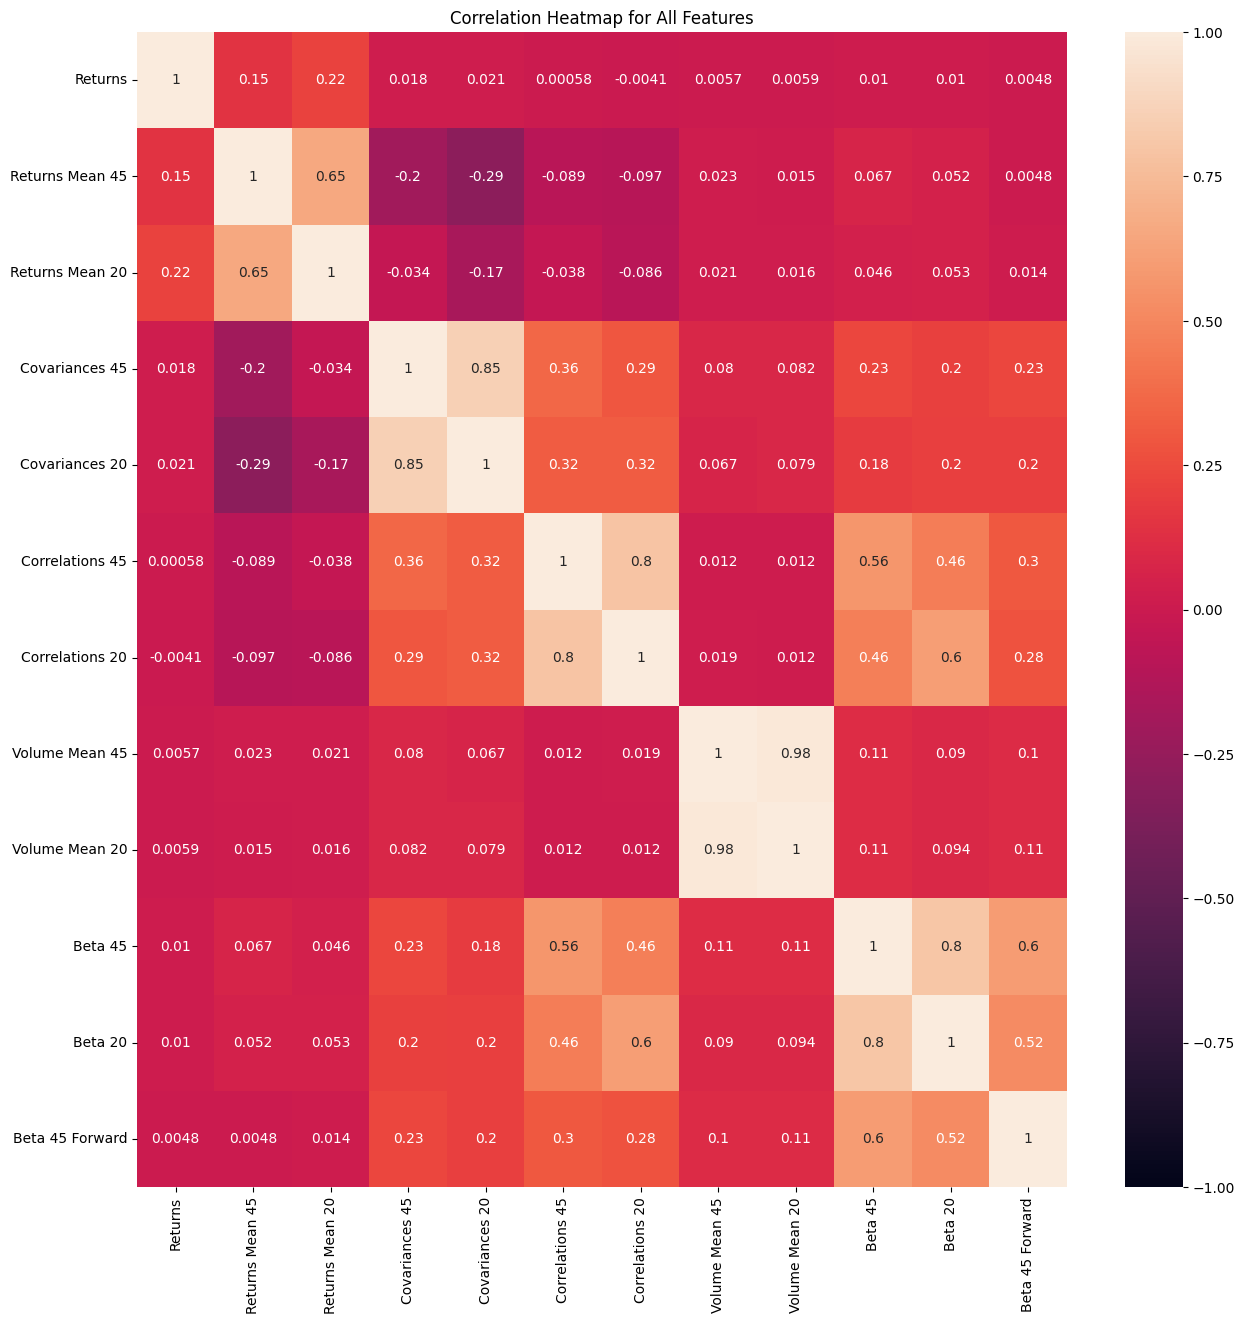

In [178]:
# Correlation matrix of the features
corr=df_all_features_flat.corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

# Set the title
plt.title('Correlation Heatmap for All Features')

# Show the plot
plt.show()

### From the correlation matrix we can see that Daily Returns are not very correlated to our target value so we will drop it in the following analysis. We keep the mean returns since the models were found to perform better by incuding them. We also drop Volume 20 since it's highly correlated to Volume 45.

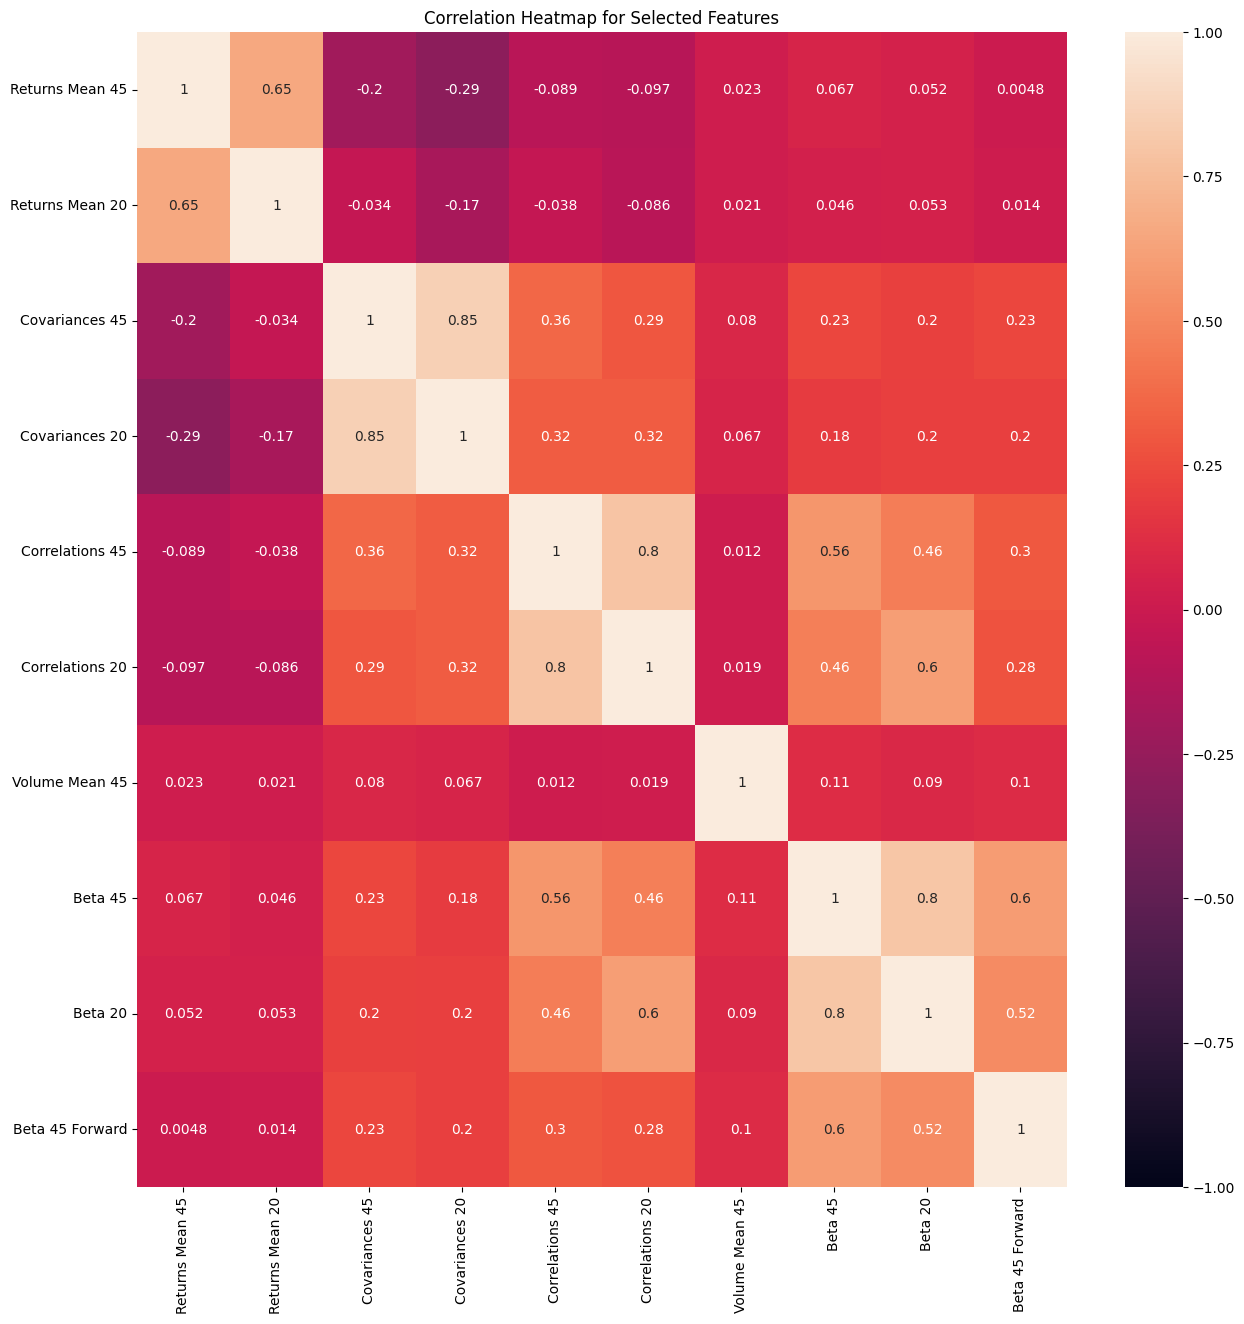

In [179]:
df_preprocessed = df_all_features_flat.drop(columns=['Returns', 'Volume Mean 20'])

# Correlation matrix of the selected features
corr=df_preprocessed.corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

# Set the title
plt.title('Correlation Heatmap for Selected Features')

# Show the plot
plt.show()

In [180]:
# Get some statistics on our preprocessed data
df_preprocessed.describe()

,Returns Mean 45,Returns Mean 20,Covariances 45,Covariances 20,Correlations 45,Correlations 20,Volume Mean 45,Beta 45,Beta 20,Beta 45 Forward
count,390260.000000,390260.000000,390260.000000,390260.000000,390260.000000,390260.000000,3.902600e+05,390260.000000,390260.000000,390260.000000
mean,0.000683,0.000682,0.000157,0.000158,0.541520,0.537424,8.997640e+06,1.018187,1.017401,1.015455
std,0.002960,0.004543,0.000335,0.000392,0.219180,0.262094,2.375199e+07,0.537253,0.670675,0.539200
min,-0.037835,-0.073563,-0.000232,-0.000426,-0.583878,-0.735717,4.987778e+04,-6.077315,-12.566920,-6.077315
25%,-0.000738,-0.001468,0.000035,0.000027,0.404491,0.377638,1.422125e+06,0.675826,0.621987,0.671868
50%,0.000749,0.000781,0.000066,0.000061,0.569950,0.583724,3.112691e+06,0.978239,0.969340,0.976471
75%,0.002176,0.002914,0.000137,0.000139,0.708505,0.741423,6.927608e+06,1.305445,1.352870,1.304999
max,0.050499,0.082316,0.004579,0.006803,0.966688,0.989685,6.117439e+08,5.660522,7.595923,5.660522


# Split into train, test data

In [181]:
X = df_preprocessed.drop('Beta 45 Forward', axis=1)
y = df_preprocessed['Beta 45 Forward']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Load, train and evaluate models
### In this case we use 3 of the most common and usually best performing models for regression problems: Linear Regression, Random Forest Regressor, and Gradient Boosting Regressor

In [182]:
# Load models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=123),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=123)
}

results = {}

# Get baseline results
results['Baseline'] = {
    'RMSE': df_preprocessed['Beta 45'].std(),
    'R2': 0
}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'RMSE': rmse,
        'R2': r2
    }

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                       RMSE        R2
Baseline           0.537253  0.000000
Linear Regression  0.423726  0.381791
Random Forest      0.266358  0.755714
Gradient Boosting  0.401427  0.445145


### We evaluate all 3 models and compared them to a 'Baseline' model. This 'Baseline' model predicts the 45-day forward-looking beta as the mean of the target every time. Note that the RMSE and $R^2$ of the baseline model are the target STD and 0, respectively, by definition.

### We see that the best performing model is the Random Forest Regressor with a RMSE of 0.27 and an $R^2$ score of 0.76

### Let's interpret this results: 
### 1) The Random Forest RMSE corresponds to a 50% decrease compared to the data STD, this is a significant improvement over guessing the mean. 
### 2) The Random Forest $R^2$ score of 0.76 implies that 76% of the variance in the target variable is explained by this model, compared to 0% in a model that guesses the mean every time.

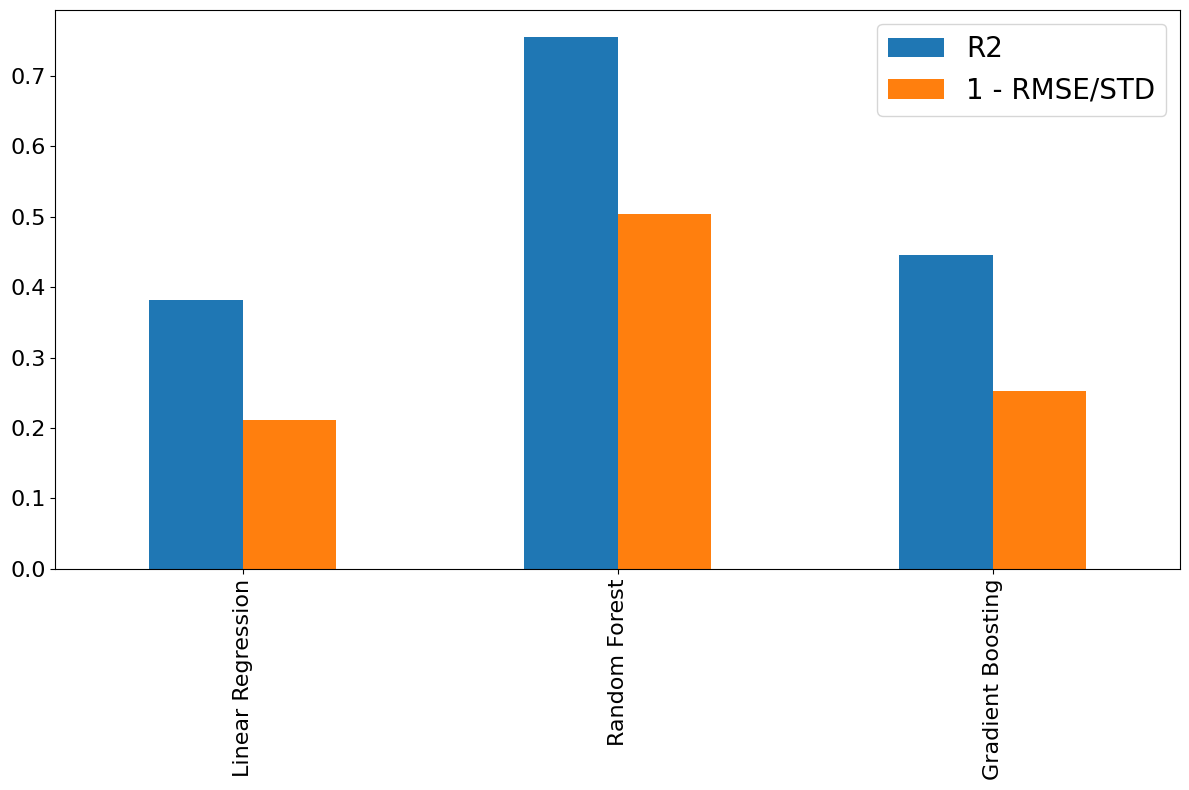

In [184]:
# Create another feature '1 - RMSE/STD' to better compare how the model improves on the target's STD
results_df2 = results_df.copy()
results_df2['1 - RMSE/STD'] = 1 - results_df2['RMSE']/df_preprocessed['Beta 45'].std()
results_df2.drop(columns=['RMSE'], inplace=True)
results_df2 = results_df2.iloc[1:,:]

# Update rcParams for font sizes
plt.rcParams.update({
    'axes.labelsize': 16,  # Font size for x and y labels
    'xtick.labelsize': 12,  # Font size for x-axis tick labels
    'ytick.labelsize': 12   # Font size for y-axis tick labels
})

# Plot Results
plt.rc('legend',fontsize=20)
fig, ax = plt.subplots(figsize=(10, 5))
results_df2.plot(kind='bar', figsize=(12, 8), fontsize=16, ax=ax)
fig.tight_layout()
fig.savefig('Beta_Model_eval.jpg', dpi=100)

# Feature Importance Extraction

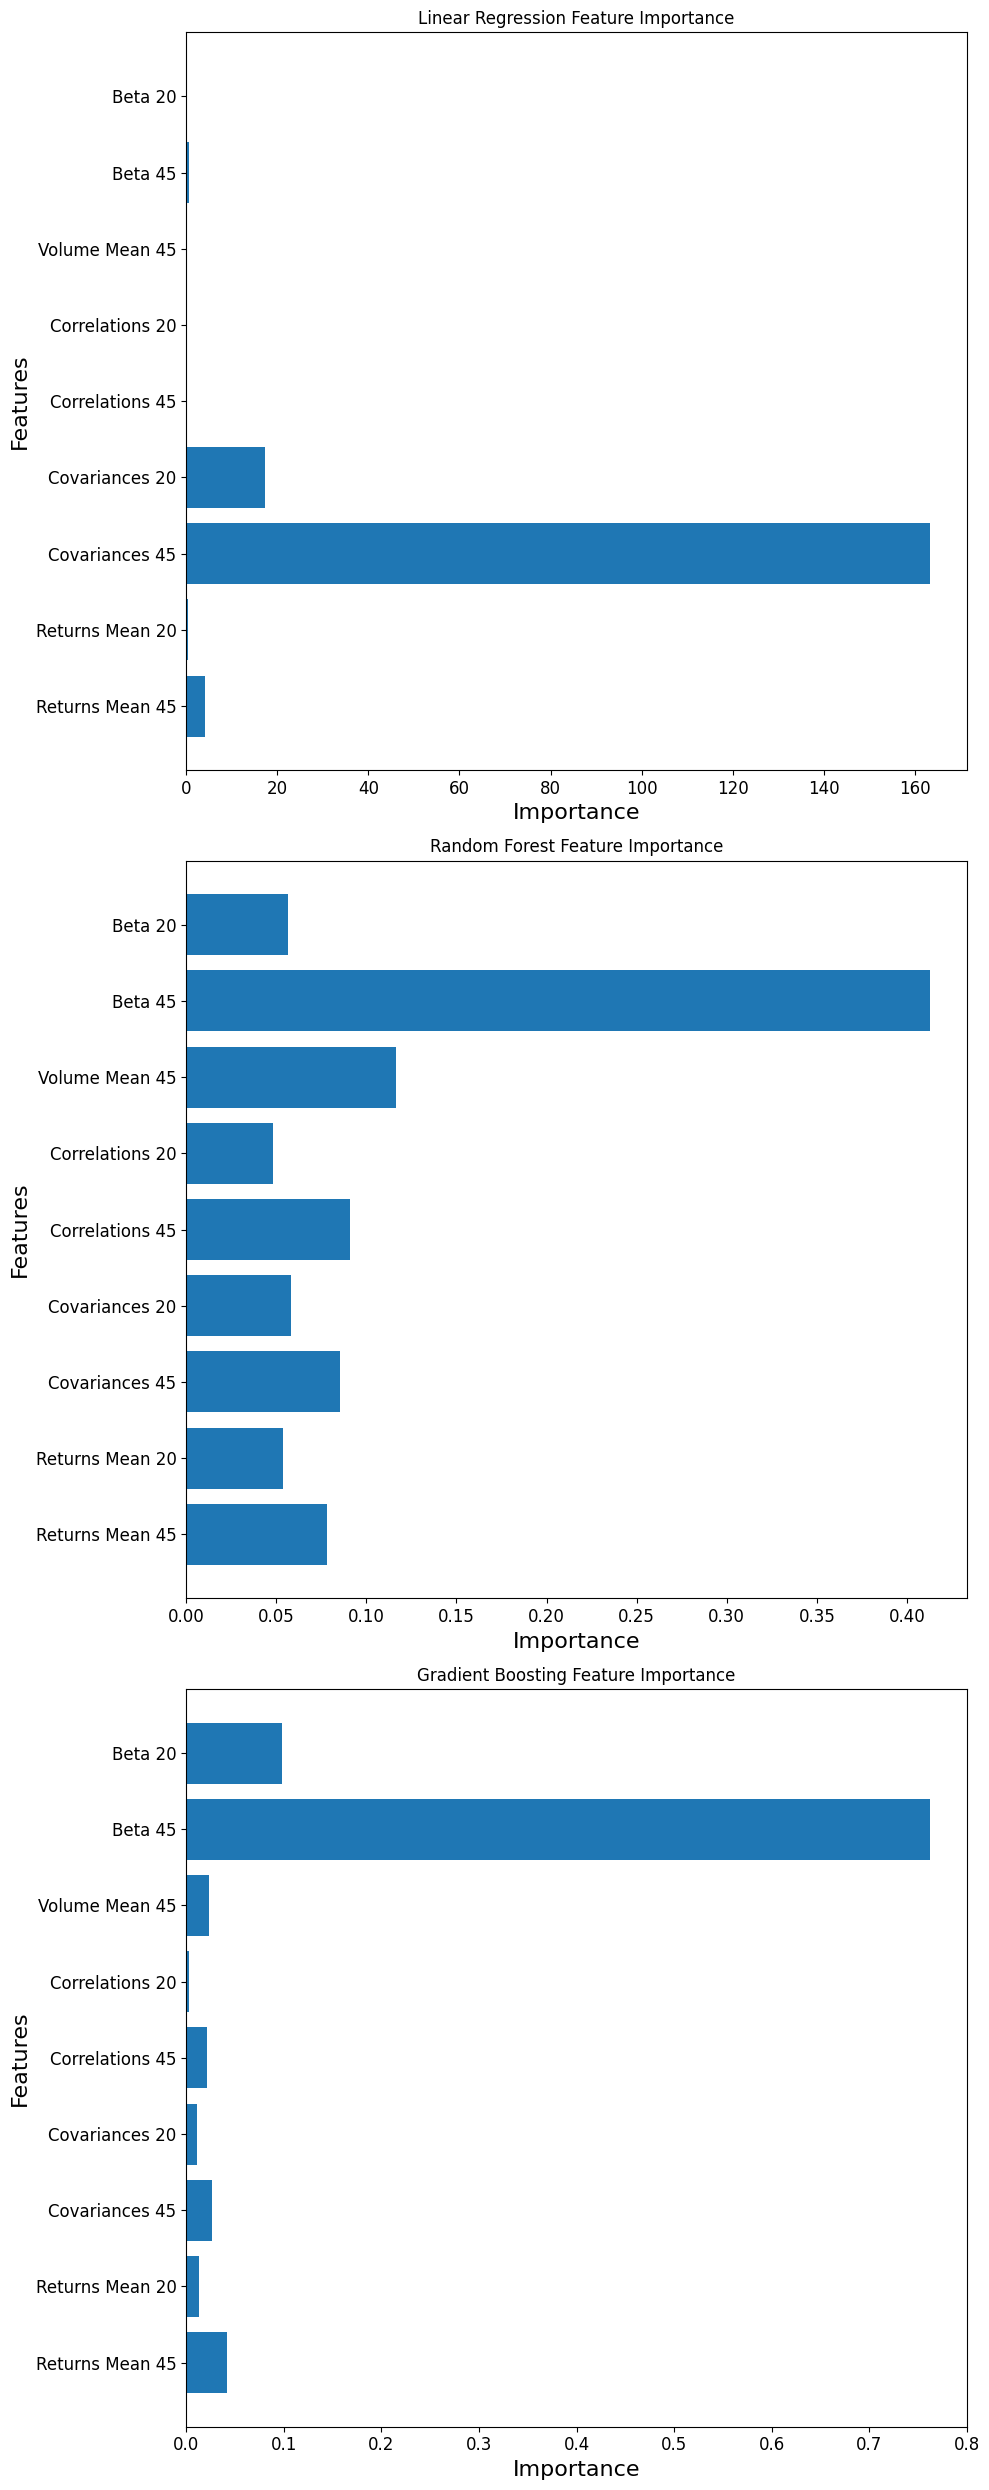

In [185]:
# Now we extract the feature importance or coefficients
importance = {}

# For Linear Regression, use the absolute value of the coefficients
importance['Linear Regression'] = np.abs(models['Linear Regression'].coef_)

# For Random Forest and Gradient Boosting, use the feature_importances_ attribute
importance['Random Forest'] = models['Random Forest'].feature_importances_
importance['Gradient Boosting'] = models['Gradient Boosting'].feature_importances_


# Extract features
features = X.columns

# Plot feature importance for each model in a bar plot
fig, ax = plt.subplots(3,1,figsize=(10, 25))

for i, (name, imp) in enumerate(importance.items(), start=1):
    ax[i-1].barh(features, imp)
    ax[i-1].set_title(f'{name} Feature Importance')
    ax[i-1].set_xlabel('Importance')
    ax[i-1].set_ylabel('Features')
fig.tight_layout()
fig.savefig('Beta_Feature_imp.jpg', dpi=100)

### Interestingly, the results show that for linear regression, the 45-day past Covariances are the most relevant feature by far. However, for the RF and GB Regressors the 45-day past Beta is the largest predictor of the 45-day future beta.